## Import

In [1]:
%env CUDA_VISIBLE_DEVICES=2,3
!echo $CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=2,3
2,3


In [25]:
import torch
import matplotlib.pyplot as plt

In [26]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [9]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

## Load model

In [6]:
%run ../models/report_generation/__init__.py
%run ../models/checkpoint/__init__.py

In [7]:
run_name = '0716_211601_lstm-att_lr0.0001_densenet-121'
debug = False

In [10]:
compiled_model = load_compiled_model_report_generation(run_name,
                                                       debug=debug,
                                                       device=DEVICE,
                                                      )

_ = compiled_model.model.eval()
compiled_model.metadata['decoder_kwargs']

{'decoder_name': 'lstm-att',
 'vocab_size': 1775,
 'embedding_size': 100,
 'hidden_size': 100,
 'features_size': [1024, 16, 16],
 'teacher_forcing': True}

In [11]:
VOCAB = compiled_model.metadata['vocab']
len(VOCAB)

1775

## Load data

In [12]:
%run ../datasets/iu_xray.py
%run ../utils/nlp.py

In [13]:
dataset_kwargs = {
    'max_samples': None,
    'frontal_only': False,
    'image_size': (512, 512),
    'vocab': VOCAB,
}

train_dataset = IUXRayDataset(dataset_type='train', **dataset_kwargs)
val_dataset = IUXRayDataset(dataset_type='val', **dataset_kwargs)
test_dataset = IUXRayDataset(dataset_type='test', **dataset_kwargs)
len(train_dataset), len(val_dataset), len(test_dataset)

(5923, 751, 752)

## Eval

In [37]:
from captum.attr import visualization
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize

In [19]:
def eval_sample(compiled_model, image, report,
                show=True, device=DEVICE, free=False, **kwargs):
    report_reader = ReportReader(compiled_model.metadata['vocab'])
    
    is_hierarchical = compiled_model.metadata['decoder_kwargs']['decoder_name'].startswith('h-')
    
    # Prepare inputs
    images = image.unsqueeze(0).to(device)
    if is_hierarchical:
        reports = split_sentences_and_pad(report)
    else:
        reports = torch.tensor(report)

    reports = reports.unsqueeze(0).to(device)
    
    # Pass thru model
    if not is_hierarchical:
        del kwargs['max_sentences']
    tup = compiled_model.model(images, reports, free=free, **kwargs)
    
    # Parse outputs
    if is_hierarchical:
        generated = _flatten_gen_reports(tup[0], tup[1])
    else:
        generated = tup[0]
        _, generated = generated.max(dim=-1)

    generated = generated.squeeze(0).cpu()
    
    # Print result
    original_report = report_reader.idx_to_text(report)
    generated_report = report_reader.idx_to_text(generated)
    if show:
        print(original_report)
        print('-'*20)
        print(generated_report)
        
    return original_report, generated_report, tup

In [40]:
idx = 100

item = train_dataset[idx]
image = item.image
report = item.report

gt, gen, other = eval_sample(compiled_model, image, report,
                             free=True, max_sentences=100, max_words=100)

both lungs are clear and expanded . heart and mediastinum normal .
--------------------
the heart size is normal . there is no focal consolidation , pneumothorax , or pleural effusion . there is no pneumothorax or pleural effusion . there is no acute bony abnormality . END


In [41]:
scores = other[1].detach().cpu()
scores = scores[0]
scores.size()

torch.Size([34, 16, 16])

In [42]:
image_color = image.detach().permute(1, 2, 0).cpu().numpy()
image_color = arr_to_range(image_color)

image_color.shape

(512, 512, 3)

In [49]:
word_idx = 10
heatmap = scores[word_idx].numpy()
heatmap = gray2rgb(heatmap)
heatmap = resize(heatmap, image_color.shape)
heatmap.shape

(512, 512, 3)

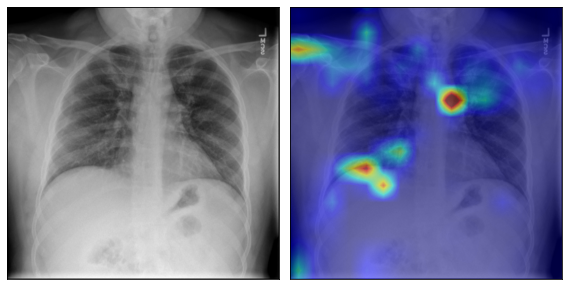

(<Figure size 576x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d3d203c50>,
       dtype=object))

In [50]:
visualization.visualize_image_attr_multiple(heatmap,
                                            image_color,
                                            methods=['original_image',
                                                     'blended_heat_map'],
                                            signs=['all', 'positive'],
                                            cmap='jet',
                                           )

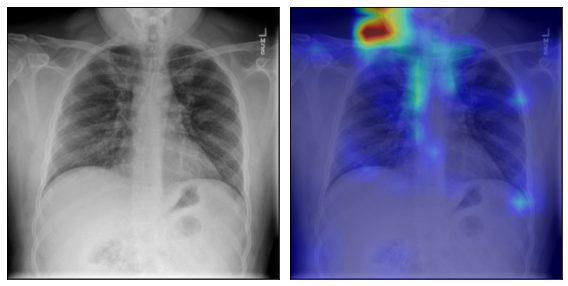

(<Figure size 576x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d3d2f5668>,
       dtype=object))

In [48]:
visualization.visualize_image_attr_multiple(heatmap,
                                            image_color,
                                            methods=['original_image',
                                                     'blended_heat_map'],
                                            signs=['all', 'positive'],
                                            cmap='jet',
                                           )